In [493]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [300]:
# show a list of images
def show(imgs, col=5, titles=None, gray=True):
    row = max((len(imgs) + col - 1) // col, 2)
    plt.figure(figsize=(col * 2.5, row * 2))
    
    for i in range(len(imgs)):
        ax = plt.subplot(row, col, i + 1)
        if gray:
            plt.imshow(imgs[i], 'gray')
        else:
            plt.imshow(imgs[i])
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")

In [464]:
# general image utils

# get boundary of foreground
def get_boundary(img, axis):
    emp = np.where(np.sum(img, axis=axis) == 0)[0]
    diff = (emp - np.roll(emp, 1))[1:]
    lo = emp[np.where(diff != 1)[0][0]]
    hi = emp[np.where(diff != 1)[0][-1] + 1]
    return lo, hi


# remove all padding around foreground
def remove_padding(img):
    top, bottom = get_boundary(img, 0)
    left, right = get_boundary(img, 1)
    return img[left:right + 1, top:bottom + 1]


# pad image to center given coordinate
def pad_to_center_coord(img, x_c, y_c):
    h, w = img.shape
    
    pad_width = [
        (int(max(h - y_c * 2, 0)), int(max(y_c * 2 - h, 0))),
        (int(max(w - x_c * 2, 0)), int(max(x_c * 2 - w, 0)))
    ]
    
    img = np.pad(img, pad_width, mode='constant', constant_values=0)
    return img


def get_centroid(img):
    
    h, w = img.shape

    m00 = img.sum()

    y = np.repeat(np.expand_dims(np.array(range(h)), 1), w, 1)
    m01 = np.multiply(y, img).sum()

    x = np.repeat(np.expand_dims(np.array(range(w)), 0), h, 0)
    m10 = np.multiply(x, img).sum()

    x_c = int(m10 // m00)
    y_c = int(m01 // m00)

    return x_c, y_c


def pad_to_square(img, n):
    h, w = img.shape
    top = (n - h) // 2
    bottom = (n - h + 1) // 2
    left = (n - w) // 2
    right = (n - w + 1) // 2
    img_square = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return img_square

In [388]:
# aran utils

# get aspect ratio based on aran
def get_aran(img):
    img = remove_padding(img)
    shape = sorted(img.shape)
    r_init = shape[0] / shape[1]
    aran = math.sin(math.pi / 2 * r_init) ** 0.5
    return aran


# pad image based on aran
def pad_to_aspect_ratio(img, aspect_ratio):

    h, w = img.shape

    # make aspect_ratio = target w / h, it was always < 1 before this
    if w > h:
        aspect_ratio = 1 / aspect_ratio

    # two possible shape:
    # a = (h, aspect_ratio * h)
    # b = (w / aspect_ratio, w)
    diff_h, diff_w = 0, 0
    if aspect_ratio * h > w:
        diff_w += int((aspect_ratio * h - w) // 2)
    elif w / aspect_ratio > h:
        diff_h += int((w / aspect_ratio - h) // 2)

    pad_width = [(diff_h, diff_h), (diff_w, diff_w)]

    img = np.pad(img, pad_width, mode='constant', constant_values=0)
    return img


# resize image based on aran
def resize_to_aspect_ratio(img, aspect_ratio):

    h, w = img.shape

    # make aspect_ratio = target w / h, it was always < 1 before this
    if w > h:
        aspect_ratio = 1 / aspect_ratio

    # two possible shape:
    # a = (h, aspect_ratio * h)
    # b = (w / aspect_ratio, w)
    diff_h, diff_w = 0, 0
    if aspect_ratio * h > w:
        img = cv2.resize(img, (h, int(aspect_ratio * h // 2 * 2)))
    elif w / aspect_ratio > h:
        img = cv2.resize(img, (int((w / aspect_ratio) // 2 * 2), w))

    return img

In [389]:
# interpolation utils

def interpolate_bilinear(x, y, img=None, imgs=None):
    
    if img is not None:
        h, w = img.shape
        img = np.concatenate([img, np.zeros((h, 1))], axis=1)
        img = np.concatenate([img, np.zeros((1, w + 1))], axis=0)
        h, w = img.shape

    vals = []
    for is_x_right in [0, 1]:
        for is_y_right in [0, 1]:
            
            if imgs is not None:
                img = imgs[is_x_right][is_y_right]
                h, w = img.shape
                img = np.concatenate([img, np.zeros((h, 1))], axis=1)
                img = np.concatenate([img, np.zeros((1, w + 1))], axis=0)
                h, w = img.shape
            
            if not is_x_right:
                x_weight = 1 - (np.array(x) % 1)
                x_coords = np.floor(x).astype(int)
            else:
                x_weight = np.array(x) % 1
                x_coords = np.ceil(x).astype(int)
            if not is_y_right:
                y_weight = 1 - (np.array(y) % 1)
                y_coords = np.floor(y).astype(int)
            else:
                y_weight = np.array(y) % 1
                y_coords = np.ceil(y).astype(int)


            tmp1, tmp2 = np.meshgrid(x_weight, y_weight)
            tmp = np.vstack([tmp1.ravel(), tmp2.ravel()]).reshape((2, len(y), len(x)))

            subval = img[y_coords, :]
            subval = subval[:, x_coords]
            tmp = np.concatenate([tmp, np.expand_dims(subval, 0)], axis=0)

            vals.append(tmp.prod(axis=0))

    retval = np.array(vals).sum(axis=0)
    return retval

In [412]:
# MN/BMN utils

def get_second_moment(img, one_sided=False):
    
    h, w = img.shape
    x_c, y_c = get_centroid(img)
    
    tmp_m02 = np.multiply(
        np.square((np.array(range(h)) - y_c)), 
        img.sum(axis=1)
    )

    tmp_m20 = np.multiply(
        np.square((np.array(range(w)) - x_c)), 
        img.sum(axis=0)
    )
    
    if one_sided:
        m02_minus = tmp_m02[range(y_c)].sum()
        m02_plus = tmp_m02[range(y_c + 1, len(tmp_m02))].sum()
        m20_minus = tmp_m20[range(x_c)].sum()
        m20_plus = tmp_m20[range(x_c + 1, len(tmp_m20))].sum()
        return m02_minus, m02_plus, m20_minus, m20_plus
    else:
        m02 = tmp_m02.sum()
        m20 = tmp_m20.sum()
        return m02, m20
    
    
# find scaling and new boundary for MN
def get_mn_scaling(img, alpha=4):
    
    m02, m20 = get_second_moment(img)
    delta_y = alpha * m02 ** 0.5
    delta_x = alpha * m20 ** 0.5
    
    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    delta_y_half = int(delta_y // 2)
    delta_x_half = int(delta_x // 2)
    bound_x = (x_c - delta_x_half, x_c + delta_x_half)
    bound_y = (y_c - delta_y_half, y_c + delta_y_half)
    
    return delta_x, delta_y, bound_x, bound_y
    
    
# find new boundary for BMN
def get_bmn_scaling(img, alpha=None, beta=2):

    moments = get_second_moment(img, one_sided=True)
    m02_minus, m02_plus, m20_minus, m20_plus = moments

    delta_y_minus = m02_minus ** 0.5 * beta
    delta_y_plus = m02_plus ** 0.5 * beta
    delta_x_minus = m20_minus ** 0.5 * beta
    delta_x_plus = m20_plus ** 0.5 * beta

    h, w = img.shape
    y_c = h // 2
    x_c = w // 2

    bound_x = (int(x_c - delta_x_minus), int(x_c + delta_x_plus))
    bound_y = (int(y_c - delta_y_minus), int(y_c + delta_y_plus))

    return bound_x, bound_y


def get_mn_mapping(img, x_c_init, y_c_init, alpha=4, beta=None):
    
    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    delta_x, delta_y, bound_x, bound_y = get_mn_scaling(img, alpha=alpha)

    # coordinate mapping
    x = np.array(range(bound_x[0], bound_x[1]))
    y = np.array(range(bound_y[0], bound_y[1]))
    x_mapped = (x - x_c_init) * w / delta_x + x_c
    x_mapped = np.clip(x_mapped, a_min=0, a_max=w)
    y_mapped = (y - y_c_init) * h / delta_y + y_c
    y_mapped = np.clip(y_mapped, a_min=0, a_max=h)
    
    return x_mapped, y_mapped


def get_bmn_mapping(img, x_c_init, y_c_init, beta=2, alpha=None):

    h, w = img.shape
    y_c = h // 2
    x_c = w // 2

    bound_x, bound_y = get_bmn_scaling(img, beta=beta)

    a1, b1, c1 = np.polyfit(
        [bound_x[0], x_c, bound_x[1]], 
        [0, w//2, w], 
        2
    )

    a2, b2, c2 = np.polyfit(
        [bound_y[0], y_c, bound_y[1]], 
        [0, h//2, h], 
        2
    )

    # TODO: find limit curve range? while loop moving value at 0.5 down?
    x = np.array(range(bound_x[0], bound_x[1]))
    x_mapped = a1 * x ** 2 + b1 * x + c1
    x_mapped = np.clip(x_mapped, a_min=0, a_max=w)

    y = np.array(range(bound_y[0], bound_y[1]))
    y_mapped = a2 * y ** 2 + b2 * y + c2
    y_mapped = np.clip(y_mapped, a_min=0, a_max=h)
    
    return x_mapped, y_mapped


def interpolate_mn(img, x_mapped, y_mapped):
    
    # img ---coord_mapping---> img_mapped ---downsample---> img_scaled

    # coordinates after downsampling
    y_scaled = [i * y_mapped.shape[0] / (h) for i in range(h)]
    x_scaled = [i * x_mapped.shape[0] / (w) for i in range(w)]

    # get required coordinates in img_mapped for downsampling
    x_scaled_floor = np.floor(x_scaled).astype(int)
    x_scaled_ceil = np.ceil(x_scaled).astype(int)
    y_scaled_floor = np.floor(y_scaled).astype(int)
    y_scaled_ceil = np.ceil(y_scaled).astype(int)

    # get required coordinates in img_mapped for downsampling and interpolation
    x_mapped_a = x_mapped[x_scaled_floor]
    x_mapped_b = x_mapped[x_scaled_ceil]
    y_mapped_a = y_mapped[y_scaled_floor]
    y_mapped_b = y_mapped[y_scaled_ceil]


    # update x_scaled, y_scaled to be relative to the mapped coordinates
    x_scaled = (np.array(x_scaled) % 1) + range(len(x_scaled))
    y_scaled = (np.array(y_scaled) % 1) + range(len(y_scaled))

    # interpolate required coordinates in the scaled image
    imgs_scaled = [
        [interpolate_bilinear(x_mapped_a, y_mapped_a, img), 
         interpolate_bilinear(x_mapped_a, y_mapped_b, img)],
        [interpolate_bilinear(x_mapped_b, y_mapped_a, img), 
         interpolate_bilinear(x_mapped_b, y_mapped_b, img)]
    ]
    img = interpolate_bilinear(x_scaled, y_scaled, imgs=imgs_scaled)
        
    img = (img > img.max() / 2).astype(int)
    
    return img > 0

In [413]:
# normalization utils

from skimage.morphology import skeletonize


def moment_normalization(img, mapping_func, alpha=4, beta=2):

    # move centroid to center
    x_c_init, y_c_init = get_centroid(img)
    img = pad_to_center_coord(img, x_c_init, y_c_init)

    # resize based on aran
    img = resize_to_aspect_ratio(img, get_aran(img))

    h, w = img.shape
    
    x_mapped, y_mapped = mapping_func(img, x_c_init, y_c_init, alpha=alpha, beta=beta)

    img = interpolate_mn(img, x_mapped, y_mapped)
    return img


def moment_normalization_skel(img, mapping_func, alpha=4, beta=2):
    
    img_skel = skeletonize((img // 255).astype('uint8')).astype('uint8')

    # move centroid to center
    x_c_init, y_c_init = get_centroid(img)
    img = pad_to_center_coord(img, x_c_init, y_c_init)
    img_skel = pad_to_center_coord(img_skel, x_c_init, y_c_init)

    # resize based on aran
    ar = get_aran(img)
    img = resize_to_aspect_ratio(img, ar)
    img_skel = resize_to_aspect_ratio(img_skel, ar)

    h, w = img.shape

    x_mapped, y_mapped = mapping_func(img_skel, x_c_init, y_c_init, alpha=alpha, beta=beta)

    img = interpolate_mn(img, x_mapped, y_mapped)
    
    return img

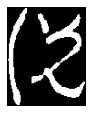

In [477]:
fname = '../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png'
fname = '../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png'
fname = '../data/shufadict/clean/发/2fc5822be330238690204267753d14c2.png'
fname = '../data/shufadict/clean/发/25c7c8b5d972ffd69870296df43a6884.png'
fname = '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png'
fname = '../data/shufadict/clean/而/9b00ab5a91f79fca33e8a8c1c0872643.png'
fname = '../data/shufadict/clean/而/f1e2bd97b285035a03de31e17fb0fd1a.png'
fname = '../data/shufadict/clean/说/2bed014d30fb1c554f84abeb24d64e6f.png'
# fname = '../data/shufadict/clean/说/4aa84d1b2c3528603b4c7e63dd9e0b8b.png'
# fname = '../data/shufadict/clean/那/8f5a4f9759115f2dc758d2253019c559.png'
# fname = '../data/shufadict/clean/那/af052eb17df40cf2de16c4c748991964.png'

img_init = cv2.imread(fname)[:, :, 0]
img_init = remove_padding(img_init)
show([img_init])

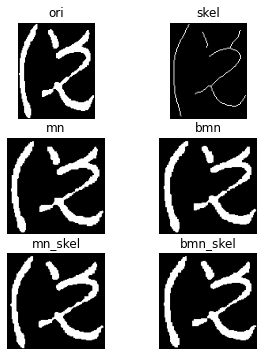

In [478]:
img_mn = moment_normalization(img_init, get_mn_mapping, alpha=4)
img_bmn = moment_normalization(img_init, get_bmn_mapping, alpha=4)
img_mn_skel = moment_normalization_skel(img_init, get_mn_mapping, alpha=4)
img_bmn_skel = moment_normalization_skel(img_init, get_bmn_mapping, alpha=4)
show(
    [img_init, skeletonize(img_init//255), img_mn, img_bmn, img_mn_skel, img_bmn_skel], 
    col=2, 
    titles=['ori', 'skel', 'mn', 'bmn', 'mn_skel', 'bmn_skel']
)

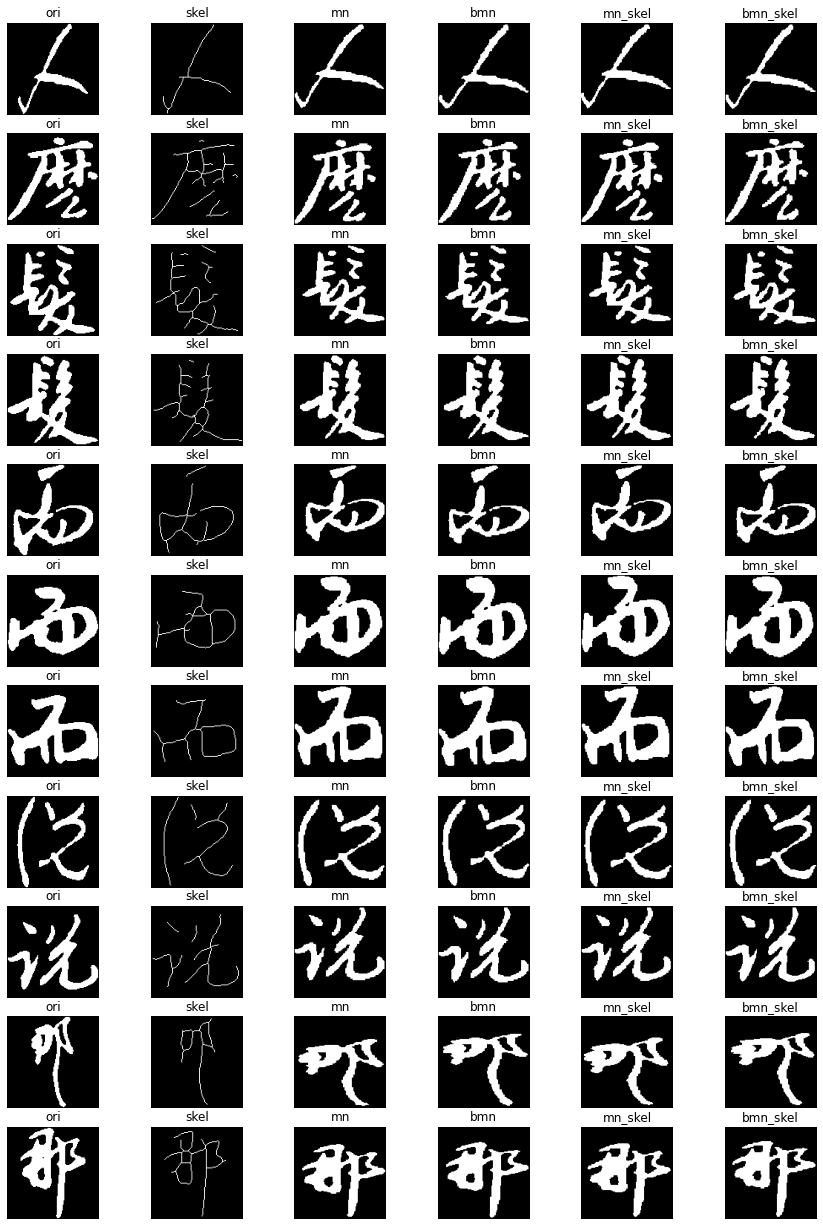

In [481]:
imgs = []
titles = []
fnames = [
    '../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png',
    '../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png',
    '../data/shufadict/clean/发/2fc5822be330238690204267753d14c2.png',
    '../data/shufadict/clean/发/25c7c8b5d972ffd69870296df43a6884.png',
    '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png',
    '../data/shufadict/clean/而/9b00ab5a91f79fca33e8a8c1c0872643.png',
    '../data/shufadict/clean/而/f1e2bd97b285035a03de31e17fb0fd1a.png',
    '../data/shufadict/clean/说/2bed014d30fb1c554f84abeb24d64e6f.png',
    '../data/shufadict/clean/说/4aa84d1b2c3528603b4c7e63dd9e0b8b.png',
    '../data/shufadict/clean/那/8f5a4f9759115f2dc758d2253019c559.png',
    '../data/shufadict/clean/那/af052eb17df40cf2de16c4c748991964.png'
]
for fname in fnames:
    img_init = cv2.imread(fname)[:, :, 0]
    img_init = remove_padding(img_init)
    img_mn = moment_normalization(img_init, get_mn_mapping, alpha=4)
    img_bmn = moment_normalization(img_init, get_bmn_mapping, alpha=4)
    img_mn_skel = moment_normalization_skel(img_init, get_mn_mapping, alpha=4)
    img_bmn_skel = moment_normalization_skel(img_init, get_bmn_mapping, alpha=4)
    imgs += [img_init, skeletonize(img_init//255), img_mn, img_bmn, img_mn_skel, img_bmn_skel]
    titles += ['ori', 'skel', 'mn', 'bmn', 'mn_skel', 'bmn_skel']

imgs = [pad_to_square((img > 0).astype('uint8'), max(img.shape)) for img in imgs]
show(imgs, col=6, titles=titles)

---

In [492]:
os.path.listdir('../data/shufadict/clean/人')

NameError: name 'os' is not defined

In [ ]:
imgs = []
fnames = [
    '../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png',
    '../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png',
    '../data/shufadict/clean/发/2fc5822be330238690204267753d14c2.png',
    '../data/shufadict/clean/发/25c7c8b5d972ffd69870296df43a6884.png',
    '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png',
    '../data/shufadict/clean/而/9b00ab5a91f79fca33e8a8c1c0872643.png',
    '../data/shufadict/clean/而/f1e2bd97b285035a03de31e17fb0fd1a.png',
    '../data/shufadict/clean/说/2bed014d30fb1c554f84abeb24d64e6f.png',
    '../data/shufadict/clean/说/4aa84d1b2c3528603b4c7e63dd9e0b8b.png',
    '../data/shufadict/clean/那/8f5a4f9759115f2dc758d2253019c559.png',
    '../data/shufadict/clean/那/af052eb17df40cf2de16c4c748991964.png'
]
for fname in fnames:
    img_init = cv2.imread(fname)[:, :, 0]
    img_init = remove_padding(img_init)
    img_mn = moment_normalization(img_init, get_mn_mapping, alpha=4)
    img_bmn = moment_normalization(img_init, get_bmn_mapping, alpha=4)
    img_mn_skel = moment_normalization_skel(img_init, get_mn_mapping, alpha=4)
    img_bmn_skel = moment_normalization_skel(img_init, get_bmn_mapping, alpha=4)
    imgs += [img_init, skeletonize(img_init//255), img_mn, img_bmn, img_mn_skel, img_bmn_skel]
    titles += ['ori', 'skel', 'mn', 'bmn', 'mn_skel', 'bmn_skel']

imgs = [pad_to_square((img > 0).astype('uint8'), max(img.shape)) for img in imgs]
show(imgs, col=6, titles=titles)

In [491]:
np.argwhere(img_bmn_skel)

array([[ 18,  48],
       [ 18,  49],
       [ 18,  50],
       ...,
       [119,  71],
       [119,  72],
       [119,  73]])

In [490]:
stats.gaussian_kde(dataset, bw_method=None, weights=None)[source]

LinAlgError: singular matrix